# Reconocimiento de cactus

## Dataset

In [1]:
# importamos paquetes
# Cargamos paquetes necesarios

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torchvision import datasets, transforms


In [7]:
batch_size = 64

# directorio de la carpeta
directorio = 'cactus_dataset2'

# aplicaré una serie de transformaciones
# 1. escalar las imágenes a 32 x 32 pixeles
# 2. convertir a tensores
transformaciones_training = transforms.Compose([transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(), 
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.ImageFolder(directorio + '/training_set', transformaciones_training) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)


# aplicaré una serie de transformaciones
# 1. escalar las imágenes a 32 x 32 pixeles
# 2. convertir a tensores
transformaciones_validacion = transforms.Compose([transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(), 
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Descargamos el conjunto de validación
testset = datasets.ImageFolder(directorio + '/validation_set', transform=transformaciones_validacion)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

# Print out some stats about the training and test data
print('Train data, number of images: ', len(trainset))
print('Test data, number of images: ', len(testset))

# specify the image classes
classes = ['cactus', 'no_cactus']

Train data, number of images:  17500
Test data, number of images:  4000


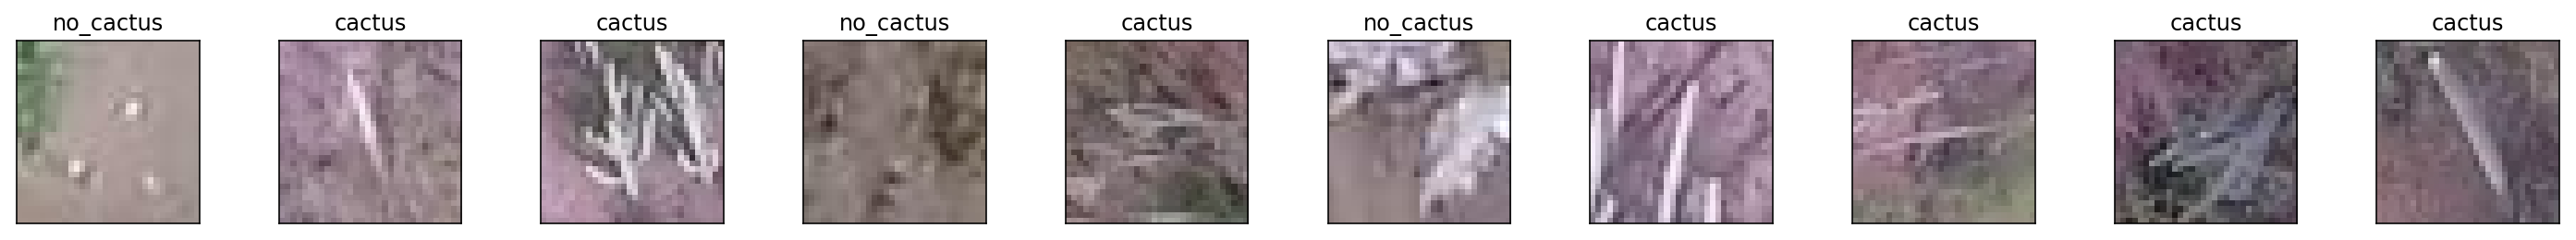

In [8]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

display_size = 10

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.numpy().transpose((1, 2, 0))
    image = (image + np.ones(image.shape))/2
    ax.imshow(image)
    ax.set_title(classes[labels[idx]])

# LeNet5

In [9]:
class LeNet5(nn.Module):
    def __init__(self, n_clases):
        '''
        Construimos la estructura de LeNet5
        
        '''
        super(LeNet5, self).__init__()
        
        # De acuerdo al artículo de LeCun La primera capa está compuesta por 6 kernels de 5x5
        self.conv1 = nn.Conv2d(3, 6, 5) # 1 canal de entrada 6 feature maps de salida, kernels de 5x5
        
        # Después tenemos una capa maxpooling
        # kernel_size=2, stride=2
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Agregamos otra capa convolucional con 16 kernels de 5 x 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Maxpooling
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_clases)
    
    def forward(self, x):
        '''
        Definimos el pase frontal (forward pass)
        '''
        # Agregamos los ReLUs
        x = self.pool1(F.relu(self.conv1(x)))
        #print(x.size())
        x = self.pool2(F.relu(self.conv2(x)))

        # prep for linear layer by flattening the feature maps into feature vectors
        x = x.view(x.size(0), -1)
        # capas lineales
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    

## Entrenamiento

In [15]:
# Create the network, define the criterion and optimizer
model = LeNet5(10)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Implementamos una función de evaluación
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        # warp input images in a Variable wrapper
        images = Variable(images)
        
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
        
        

    # forward pass to get outputs
    # the outputs are a series of class scores
    #outputs = model(images)

    # get the predicted class from the maximum value in the output-list of class scores
    #_, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    #total += labels.size(0)
    #correct += (predicted == labels).sum()

    
    return test_loss, accuracy

In [18]:
from torch.autograd import Variable

#hiperparámetro

epochs = 2
steps = 0
running_loss = 0
print_every = 40


for e in range(epochs):
    # Cambiamos a modo entrenamiento
    model.train()
    
    #for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
    #        inputs, labels = data
    
    for images, labels in trainloader:
        steps += 1
        
        # Aplanar imágenes a un vector de 784 elementos
        # images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # wrap them in a torch Variable
        images, labels = Variable(images), Variable(labels)       
        
        output = model(images)
        loss = criterion(output, labels)
        # Backpropagation
        loss.backward()
        # Optimización
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Cambiamos a modo de evaluación
            model.eval()
            
            # Apagamos los gradientes, reduce memoria y cálculos
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()

Epoch: 1/2..  Training Loss: 1.025..  Test Loss: 0.486..  Test Accuracy: 0.750
Epoch: 1/2..  Training Loss: 0.482..  Test Loss: 0.453..  Test Accuracy: 0.750
Epoch: 1/2..  Training Loss: 0.441..  Test Loss: 0.419..  Test Accuracy: 0.768
Epoch: 1/2..  Training Loss: 0.349..  Test Loss: 0.312..  Test Accuracy: 0.850
Epoch: 1/2..  Training Loss: 0.296..  Test Loss: 0.310..  Test Accuracy: 0.854
Epoch: 1/2..  Training Loss: 0.258..  Test Loss: 0.346..  Test Accuracy: 0.853
Epoch: 2/2..  Training Loss: 0.253..  Test Loss: 0.347..  Test Accuracy: 0.846
Epoch: 2/2..  Training Loss: 0.231..  Test Loss: 0.311..  Test Accuracy: 0.861
Epoch: 2/2..  Training Loss: 0.242..  Test Loss: 0.328..  Test Accuracy: 0.861
Epoch: 2/2..  Training Loss: 0.230..  Test Loss: 0.296..  Test Accuracy: 0.874
Epoch: 2/2..  Training Loss: 0.196..  Test Loss: 0.331..  Test Accuracy: 0.870
Epoch: 2/2..  Training Loss: 0.209..  Test Loss: 0.291..  Test Accuracy: 0.878
Epoch: 2/2..  Training Loss: 0.179..  Test Loss: 0.2

/home/irving/miniconda3/envs/cv-nd/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


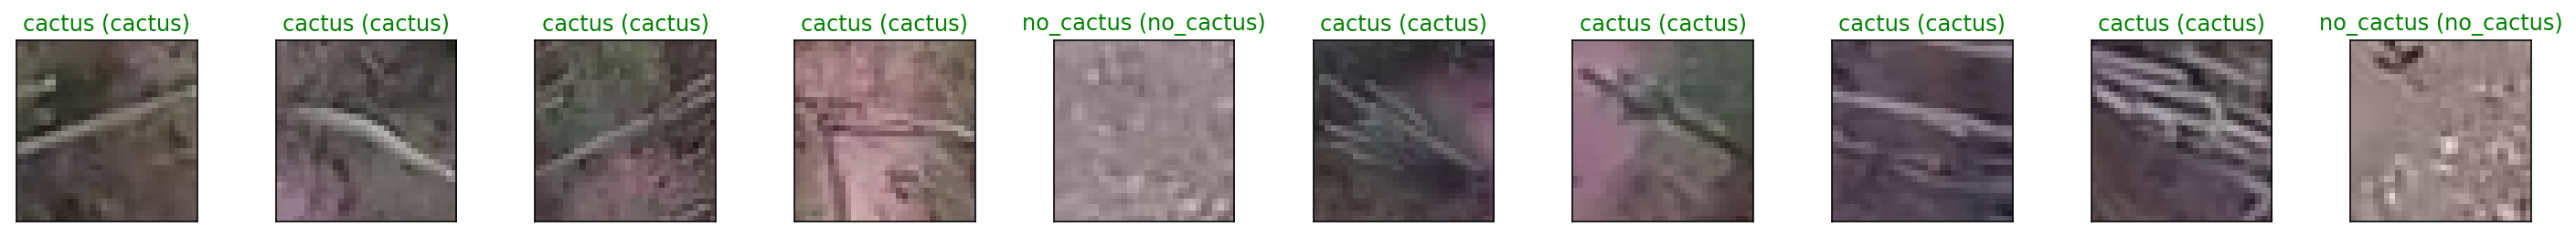

In [12]:
# obtain one batch of test images
display_size = 10

## TODO: crear un conjunto de validación
dataiter = iter(testloader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(model(Variable(images, volatile=True)).data.max(1, keepdim=True)[1].numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.numpy().transpose((1, 2, 0))
    image = (image + np.ones(image.shape))/2
    ax.imshow(image)
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [14]:
from torch.autograd import Variable

# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
# TODO
for images, labels in testloader:
    
    # warp input images in a Variable wrapper
    images = Variable(images)

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = model(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
accuracy = 100 * correct / total

# print it out!
print('Accuracy after training: ', accuracy.numpy())

Accuracy after training:  88


In [ ]:
print(accuracy.numpy())